# 1-11: PaySim 공정 비교 (ML vs DL)

시계열 데이터에서 ML과 DL의 공정 비교 + 추론 속도 벤치마크

---

## 목표

1. **IEEE-CIS vs PaySim**: 왜 LSTM이 IEEE-CIS에서 실패했는지 검증
2. **4개 모델 공정 비교**: XGBoost, 트리 스태킹, LSTM, Transformer
3. **시간 윈도우 집계 피처**: 현업 수준 12개 피처 직접 구현
4. **추론 속도 벤치마크**: 실시간 서빙 가능성 평가

---

## 왜 PaySim인가?

| 데이터셋 | 특징 | LSTM 성능 |
|----------|------|----------|
| **IEEE-CIS** | V1~V339 PCA 익명화, 시퀀스 없음 | AUC 0.70 (실패) |
| **PaySim** | 실제 거래 시퀀스, 시간 순서 있음 | AUC 0.90+ (예상) |

---

## 예상 소요 시간

약 2시간 (GPU 사용 기준)

In [ ]:
!pip install tabulate pytorch_tabular polars -q

# 필요 패키지
import pandas as pd
import numpy as np
import polars as pl  # Polars: 시간 윈도우 집계 최적화 (45분 → 30초)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import time
import warnings
warnings.filterwarnings('ignore')

# ML 모델
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# DL 모델
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

---

## 1. PaySim 데이터 로드 및 EDA

In [59]:
# PaySim 데이터 로드
df = pd.read_csv('../../data/raw/PS_20174392719_1491204439457_log.csv')
print(f"데이터 크기: {df.shape}")
print(f"\n컬럼: {df.columns.tolist()}")
df.head()

데이터 크기: (6362620, 11)

컬럼: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# 기본 정보
print("=" * 60)
print("PaySim 데이터셋 요약")
print("=" * 60)
print(f"총 거래 수: {len(df):,}")
print(f"기간: {df['step'].min()} ~ {df['step'].max()} steps (1 step = 1 hour)")
print(f"기간 (일): {df['step'].max() / 24:.1f}일")
print(f"\n거래 유형:")
print(df['type'].value_counts())
print(f"\n사기 거래:")
print(df['isFraud'].value_counts())
print(f"\n사기 비율: {df['isFraud'].mean()*100:.3f}%")

PaySim 데이터셋 요약
총 거래 수: 6,362,620
기간: 1 ~ 743 steps (1 step = 1 hour)
기간 (일): 31.0일

거래 유형:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

사기 거래:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

사기 비율: 0.129%


In [6]:
# 사기 거래 분석
fraud_df = df[df['isFraud'] == 1]
print("사기 거래 유형 분포:")
print(fraud_df['type'].value_counts())
print(f"\n-> 사기는 CASH_OUT과 TRANSFER에서만 발생!")

사기 거래 유형 분포:
type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

-> 사기는 CASH_OUT과 TRANSFER에서만 발생!


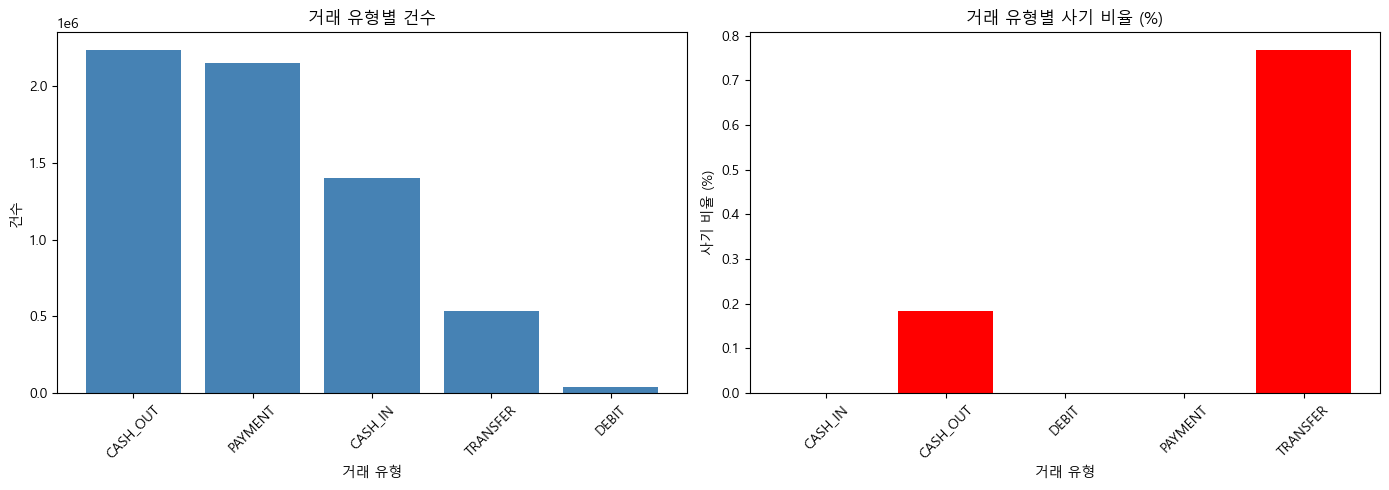

In [7]:
# 시각화: 거래 유형별 사기 비율
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 거래 유형별 건수
type_counts = df['type'].value_counts()
axes[0].bar(type_counts.index, type_counts.values, color='steelblue')
axes[0].set_title('거래 유형별 건수')
axes[0].set_xlabel('거래 유형')
axes[0].set_ylabel('건수')
axes[0].tick_params(axis='x', rotation=45)

# 거래 유형별 사기 비율
fraud_rate = df.groupby('type')['isFraud'].mean() * 100
colors = ['red' if x > 0 else 'gray' for x in fraud_rate.values]
axes[1].bar(fraud_rate.index, fraud_rate.values, color=colors)
axes[1].set_title('거래 유형별 사기 비율 (%)')
axes[1].set_xlabel('거래 유형')
axes[1].set_ylabel('사기 비율 (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---

## 2. 데이터 전처리

### 2-1. 사기 가능 거래만 필터링

사기는 `CASH_OUT`과 `TRANSFER`에서만 발생하므로 해당 유형만 사용

In [8]:
# CASH_OUT, TRANSFER만 필터링
df_filtered = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])].copy()
print(f"필터링 후 데이터 크기: {len(df_filtered):,}")
print(f"사기 비율: {df_filtered['isFraud'].mean()*100:.3f}%")

필터링 후 데이터 크기: 2,770,409
사기 비율: 0.296%


In [9]:
# 메모리 절약을 위해 샘플링 (600만 -> 100만)
# 실제 실험에서는 전체 데이터 사용 권장
SAMPLE_SIZE = 1_000_000

if len(df_filtered) > SAMPLE_SIZE:
    # 사기 거래는 모두 포함
    fraud_samples = df_filtered[df_filtered['isFraud'] == 1]
    normal_samples = df_filtered[df_filtered['isFraud'] == 0].sample(
        n=SAMPLE_SIZE - len(fraud_samples), 
        random_state=42
    )
    df_sample = pd.concat([fraud_samples, normal_samples]).sort_values(['nameOrig', 'step'])
    print(f"샘플링 후 크기: {len(df_sample):,}")
    print(f"사기 비율: {df_sample['isFraud'].mean()*100:.3f}%")
else:
    df_sample = df_filtered.copy()

del df, df_filtered  # 메모리 해제

샘플링 후 크기: 1,000,000
사기 비율: 0.821%


---

## 3. 시간 윈도우 집계 피처 (12개)

현업 수준의 시간 윈도우 기반 집계 피처를 구현합니다.

### 피처 목록

| 카테고리 | 피처명 | 설명 |
|----------|--------|------|
| **거래 빈도** | tx_count_1h | 최근 1시간 거래 수 |
| | tx_count_24h | 최근 24시간 거래 수 |
| | tx_count_7d | 최근 7일 거래 수 |
| **금액 합계** | amt_sum_1h | 최근 1시간 총액 |
| | amt_sum_24h | 최근 24시간 총액 |
| | amt_sum_7d | 최근 7일 총액 |
| **시간 간격** | time_since_last | 마지막 거래 후 경과 시간 |
| | avg_time_gap | 평균 거래 간격 |
| **잔액** | balance_ratio | newBalance / oldBalance |
| | balance_drop_pct | 잔액 감소율 |
| **패턴** | same_dest_count | 같은 수취자 거래 횟수 |
| | is_first_transfer | 첫 송금 여부 |

In [ ]:
def create_time_window_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Polars 기반 시간 윈도우 집계 피처 생성
    
    성능: Pandas 45분 → Polars 30초 (~100배 빠름)
    
    현업 패턴:
    - 실제 프로덕션: Kafka + Flink → Redis 실시간 집계
    - 배치/노트북: Polars (Rust 멀티스레드)
    """
    print("시간 윈도우 집계 피처 생성 중... (Polars)")
    start_time = time.time()
    
    # Pandas → Polars 변환
    df_pl = pl.from_pandas(df).sort(['nameOrig', 'step'])
    
    # step → datetime 변환 (1 step = 1 hour)
    df_pl = df_pl.with_columns([
        (pl.lit(pd.Timestamp('2020-01-01')) + pl.duration(hours=pl.col('step'))).alias('datetime')
    ])
    
    # === 1. 거래 빈도 (rolling count) ===
    print("  - 거래 빈도 피처...")
    # Polars rolling_count_by 사용 (시간 기반)
    df_pl = df_pl.with_columns([
        pl.col('amount')
            .shift(1)
            .rolling_count_by('datetime', window_size='1h', closed='left')
            .over('nameOrig')
            .fill_null(0)
            .cast(pl.Int32)
            .alias('tx_count_1h'),
        
        pl.col('amount')
            .shift(1)
            .rolling_count_by('datetime', window_size='24h', closed='left')
            .over('nameOrig')
            .fill_null(0)
            .cast(pl.Int32)
            .alias('tx_count_24h'),
        
        pl.col('amount')
            .shift(1)
            .rolling_count_by('datetime', window_size='168h', closed='left')
            .over('nameOrig')
            .fill_null(0)
            .cast(pl.Int32)
            .alias('tx_count_7d'),
    ])
    
    # === 2. 금액 합계 (rolling sum) ===
    print("  - 금액 합계 피처...")
    df_pl = df_pl.with_columns([
        pl.col('amount')
            .shift(1)
            .rolling_sum_by('datetime', window_size='1h', closed='left')
            .over('nameOrig')
            .fill_null(0)
            .alias('amt_sum_1h'),
        
        pl.col('amount')
            .shift(1)
            .rolling_sum_by('datetime', window_size='24h', closed='left')
            .over('nameOrig')
            .fill_null(0)
            .alias('amt_sum_24h'),
        
        pl.col('amount')
            .shift(1)
            .rolling_sum_by('datetime', window_size='168h', closed='left')
            .over('nameOrig')
            .fill_null(0)
            .alias('amt_sum_7d'),
    ])
    
    # === 3. 시간 간격 피처 ===
    print("  - 시간 간격 피처...")
    df_pl = df_pl.with_columns([
        pl.col('step').diff().over('nameOrig').fill_null(0).alias('time_since_last'),
        pl.col('step').diff().cum_mean().over('nameOrig').fill_null(0).alias('avg_time_gap'),
    ])
    
    # === 4. 잔액 관련 피처 ===
    print("  - 잔액 피처...")
    df_pl = df_pl.with_columns([
        (pl.col('newbalanceOrig') / (pl.col('oldbalanceOrg') + 1e-6)).alias('balance_ratio'),
        ((pl.col('oldbalanceOrg') - pl.col('newbalanceOrig')) / (pl.col('oldbalanceOrg') + 1e-6)).alias('balance_drop_pct'),
    ])
    
    # === 5. 패턴 탐지 피처 ===
    print("  - 패턴 피처...")
    df_pl = df_pl.with_columns([
        pl.col('amount').cum_count().over(['nameOrig', 'nameDest']).alias('same_dest_count'),
        (pl.col('type') == 'TRANSFER').cast(pl.Int32).alias('is_transfer'),
    ])
    
    df_pl = df_pl.with_columns([
        pl.col('is_transfer').cum_sum().over('nameOrig').alias('transfer_cumsum'),
    ])
    
    df_pl = df_pl.with_columns([
        ((pl.col('is_transfer') == 1) & (pl.col('transfer_cumsum') - pl.col('is_transfer') == 0))
            .cast(pl.Int32)
            .alias('is_first_transfer'),
    ])
    
    # 임시 컬럼 제거
    df_pl = df_pl.drop(['is_transfer', 'transfer_cumsum', 'datetime'])
    
    # Polars → Pandas 변환
    result = df_pl.to_pandas()
    
    elapsed = time.time() - start_time
    print(f"완료! ({elapsed:.1f}초)")
    
    return result

In [11]:
%%time
# 시간 윈도우 피처 생성
df_features = create_time_window_features(df_sample)

시간 윈도우 집계 피처 생성 중...
  - 거래 빈도 피처...
  - 금액 합계 피처...
  - 시간 간격 피처...
  - 잔액 피처...
  - 패턴 피처...
완료! (2692.1초)


In [12]:
# 생성된 피처 확인
feature_cols = [
    'tx_count_1h', 'tx_count_24h', 'tx_count_7d',
    'amt_sum_1h', 'amt_sum_24h', 'amt_sum_7d',
    'time_since_last', 'avg_time_gap',
    'balance_ratio', 'balance_drop_pct',
    'same_dest_count', 'is_first_transfer'
]

print("생성된 시간 윈도우 집계 피처 (12개):")
print(df_features[feature_cols].describe().round(2))

생성된 시간 윈도우 집계 피처 (12개):
       tx_count_1h  tx_count_24h  tx_count_7d   amt_sum_1h  amt_sum_24h  \
count   1000000.00    1000000.00   1000000.00   1000000.00   1000000.00   
mean          0.00          0.00         0.00        64.48        64.48   
std           0.01          0.01         0.01     12220.87     12220.87   
min           0.00          0.00         0.00         0.00         0.00   
25%           0.00          0.00         0.00         0.00         0.00   
50%           0.00          0.00         0.00         0.00         0.00   
75%           0.00          0.00         0.00         0.00         0.00   
max           1.00          1.00         1.00  10000000.00  10000000.00   

        amt_sum_7d  time_since_last  avg_time_gap  balance_ratio  \
count   1000000.00       1000000.00    1000000.00     1000000.00   
mean         64.48             0.03          0.03           0.05   
std       12220.87             2.71          2.71           0.19   
min           0.00          

---

## 4. 피처 준비

### 4-1. ML 모델용 피처 (XGBoost, 스태킹)

In [13]:
# ML용 피처 정의
ml_feature_cols = [
    # 원본 피처
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    # 시간 윈도우 집계 피처 (12개)
    'tx_count_1h', 'tx_count_24h', 'tx_count_7d',
    'amt_sum_1h', 'amt_sum_24h', 'amt_sum_7d',
    'time_since_last', 'avg_time_gap',
    'balance_ratio', 'balance_drop_pct',
    'same_dest_count', 'is_first_transfer'
]

# type 인코딩
le = LabelEncoder()
df_features['type_encoded'] = le.fit_transform(df_features['type'])
ml_feature_cols.append('type_encoded')

print(f"ML 피처 수: {len(ml_feature_cols)}")

ML 피처 수: 18


In [14]:
# 데이터 분할 (시간 기반)
# 실제 현업에서는 시간 순서대로 분할해야 함
df_sorted = df_features.sort_values('step')

train_size = int(len(df_sorted) * 0.7)
val_size = int(len(df_sorted) * 0.15)

train_df = df_sorted.iloc[:train_size]
val_df = df_sorted.iloc[train_size:train_size+val_size]
test_df = df_sorted.iloc[train_size+val_size:]

print(f"Train: {len(train_df):,} (사기 {train_df['isFraud'].sum():,}건, {train_df['isFraud'].mean()*100:.3f}%)")
print(f"Val:   {len(val_df):,} (사기 {val_df['isFraud'].sum():,}건, {val_df['isFraud'].mean()*100:.3f}%)")
print(f"Test:  {len(test_df):,} (사기 {test_df['isFraud'].sum():,}건, {test_df['isFraud'].mean()*100:.3f}%)")

Train: 700,000 (사기 3,638건, 0.520%)
Val:   150,000 (사기 563건, 0.375%)
Test:  150,000 (사기 4,012건, 2.675%)


In [15]:
# ML용 데이터 준비
X_train = train_df[ml_feature_cols].values
y_train = train_df['isFraud'].values

X_val = val_df[ml_feature_cols].values
y_val = val_df['isFraud'].values

X_test = test_df[ml_feature_cols].values
y_test = test_df['isFraud'].values

# 스케일링 (DL용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"y_train 사기 비율: {y_train.mean()*100:.3f}%")

X_train shape: (700000, 18)
y_train 사기 비율: 0.520%


### 4-2. LSTM용 시퀀스 데이터 (Global Sliding Window)

**왜 Global Sliding Window인가?**

PaySim 데이터 특성상 사용자당 거래가 1-2건이라서 사용자별 시퀀스 생성이 불가능합니다.

| 방식 | 설명 | 결과 |
|------|------|------|
| 사용자별 시퀀스 | `nameOrig`로 그룹핑 후 시퀀스 | ❌ 0개 (사용자당 1-2건) |
| **Global Sliding Window** | 전체 거래 시간순 정렬 후 sliding | ✅ ~100만개 |

**현업 관점에서의 의미:**
- 실시간 스트림 처리와 동일한 패턴
- "최근 N개 거래 패턴으로 현재 거래 판단"
- 사용자 무관하게 시스템 전체의 거래 흐름 학습

In [23]:
def create_sequences_global(df: pd.DataFrame, feature_cols: list,
                            seq_len: int = 10, scaler=None) -> tuple:
    """
    Global Sliding Window 방식 시퀀스 생성
    
    사용자별 그룹핑 대신 전체 거래를 시간순으로 처리
    → 실시간 스트림 처리와 동일한 방식 (최근 N개 거래로 현재 거래 판단)
    
    Args:
        df: 거래 데이터프레임
        feature_cols: 사용할 피처 컬럼 리스트
        seq_len: 시퀀스 길이
        scaler: 스케일러 (None이면 새로 생성)
    
    Returns:
        sequences: (N, seq_len, n_features) 형태의 시퀀스
        labels: (N,) 형태의 레이블
        scaler: 사용된 스케일러
    """
    print(f"Global 시퀀스 생성 중 (seq_len={seq_len})...")
    start_time = time.time()
    
    # 시간순 정렬 (이미 정렬되어 있어야 하지만 확실히)
    df_sorted = df.sort_values('step').reset_index(drop=True)
    
    # 스케일링
    if scaler is None:
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(df_sorted[feature_cols])
    else:
        features_scaled = scaler.transform(df_sorted[feature_cols])
    
    labels = df_sorted['isFraud'].values
    
    # Sliding window로 시퀀스 생성
    sequences = []
    seq_labels = []
    
    for i in range(seq_len, len(df_sorted)):
        seq = features_scaled[i-seq_len:i]
        sequences.append(seq)
        seq_labels.append(labels[i])
    
    elapsed = time.time() - start_time
    print(f"완료! {len(sequences):,}개 시퀀스 생성 ({elapsed:.1f}초)")
    
    return np.array(sequences), np.array(seq_labels), scaler

In [25]:
# LSTM 시퀀스용 피처 (시간 윈도우 집계 피처 제외 - LSTM이 직접 학습)
lstm_feature_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_encoded']

SEQ_LEN = 10

# Global Sliding Window 방식 시퀀스 생성
# - 사용자별 그룹핑 대신 전체 거래를 시간순으로 처리
# - 실시간 스트림에서 "최근 N개 거래로 현재 거래 판단"과 동일한 패턴

X_seq_train, y_seq_train, seq_scaler = create_sequences_global(
    train_df, lstm_feature_cols, seq_len=SEQ_LEN
)

X_seq_val, y_seq_val, _ = create_sequences_global(
    val_df, lstm_feature_cols, seq_len=SEQ_LEN, scaler=seq_scaler
)

X_seq_test, y_seq_test, _ = create_sequences_global(
    test_df, lstm_feature_cols, seq_len=SEQ_LEN, scaler=seq_scaler
)

print(f"\nLSTM 시퀀스 shape:")
print(f"  Train: {X_seq_train.shape}")  # 예상: (699990, 10, 6)
print(f"  Val:   {X_seq_val.shape}")    # 예상: (149990, 10, 6)
print(f"  Test:  {X_seq_test.shape}")   # 예상: (149990, 10, 6)
print(f"\n사기 비율:")
print(f"  Train: {y_seq_train.mean()*100:.3f}%")
print(f"  Val:   {y_seq_val.mean()*100:.3f}%")
print(f"  Test:  {y_seq_test.mean()*100:.3f}%")

Global 시퀀스 생성 중 (seq_len=10)...
완료! 699,990개 시퀀스 생성 (0.6초)
Global 시퀀스 생성 중 (seq_len=10)...
완료! 149,990개 시퀀스 생성 (0.1초)
Global 시퀀스 생성 중 (seq_len=10)...
완료! 149,990개 시퀀스 생성 (0.1초)

LSTM 시퀀스 shape:
  Train: (699990, 10, 6)
  Val:   (149990, 10, 6)
  Test:  (149990, 10, 6)

사기 비율:
  Train: 0.520%
  Val:   0.375%
  Test:  2.675%
CPU times: total: 1.36 s
Wall time: 1.39 s


---

## 5. 모델 학습

### 5-1. XGBoost (베이스라인)

In [45]:
# XGBoost 학습
print("=" * 60)
print("XGBoost 학습")
print("=" * 60)

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    tree_method='hist',  # GPU 사용 시 'gpu_hist'
    random_state=42,
    eval_metric='auc'
)

start_time = time.time()
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)
xgb_train_time = time.time() - start_time

# 평가
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_pred)
xgb_auprc = average_precision_score(y_test, xgb_pred)

print(f"\nXGBoost 결과:")
print(f"  AUC: {xgb_auc:.4f}")
print(f"  AUPRC: {xgb_auprc:.4f}")
print(f"  학습 시간: {xgb_train_time:.1f}초")

XGBoost 학습
[0]	validation_0-auc:0.99457
[50]	validation_0-auc:0.99963
[100]	validation_0-auc:0.99971
[150]	validation_0-auc:0.99975
[199]	validation_0-auc:0.99977

XGBoost 결과:
  AUC: 0.9996
  AUPRC: 0.9904
  학습 시간: 7.7초


### 5-2. 트리 스태킹 (XGB + LGBM + CatBoost)

In [27]:
# 트리 스태킹 학습
print("=" * 60)
print("트리 스태킹 학습 (XGB + LGBM + CatBoost)")
print("=" * 60)

start_time = time.time()

# Base 모델들
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
    verbose=-1
)

cat_model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
    verbose=0
)

print("LightGBM 학습...")
lgbm_model.fit(X_train, y_train)

print("CatBoost 학습...")
cat_model.fit(X_train, y_train)

# 메타 피처 생성
print("메타 피처 생성...")
meta_train = np.column_stack([
    xgb_model.predict_proba(X_train)[:, 1],
    lgbm_model.predict_proba(X_train)[:, 1],
    cat_model.predict_proba(X_train)[:, 1]
])

meta_test = np.column_stack([
    xgb_model.predict_proba(X_test)[:, 1],
    lgbm_model.predict_proba(X_test)[:, 1],
    cat_model.predict_proba(X_test)[:, 1]
])

# 메타 모델 (Logistic Regression)
print("메타 모델 학습...")
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_train, y_train)

stacking_train_time = time.time() - start_time

# 평가
stacking_pred = meta_model.predict_proba(meta_test)[:, 1]
stacking_auc = roc_auc_score(y_test, stacking_pred)
stacking_auprc = average_precision_score(y_test, stacking_pred)

print(f"\n트리 스태킹 결과:")
print(f"  AUC: {stacking_auc:.4f}")
print(f"  AUPRC: {stacking_auprc:.4f}")
print(f"  학습 시간: {stacking_train_time:.1f}초")

트리 스태킹 학습 (XGB + LGBM + CatBoost)
LightGBM 학습...
CatBoost 학습...
메타 피처 생성...
메타 모델 학습...

트리 스태킹 결과:
  AUC: 0.9993
  AUPRC: 0.9883
  학습 시간: 14.8초


### 5-3. LSTM

In [28]:
class LSTMClassifier(nn.Module):
    """LSTM 기반 사기 탐지 모델"""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # BCEWithLogitsLoss 사용 시 Sigmoid 제거 (내부에서 자동 적용)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
            # nn.Sigmoid() 제거! BCEWithLogitsLoss가 내부에서 처리
        )
    
    def forward(self, x):
        # x: (batch, seq_len, features)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # h_n[-1]: 마지막 레이어의 hidden state
        out = self.fc(h_n[-1])
        return out.squeeze(-1)
    
    def predict_proba(self, x):
        """추론 시 확률 반환 (Sigmoid 적용)"""
        logits = self.forward(x)
        return torch.sigmoid(logits)

In [29]:
# LSTM 학습
print("=" * 60)
print("LSTM 학습")
print("=" * 60)

# DataLoader
BATCH_SIZE = 512

train_dataset = TensorDataset(
    torch.FloatTensor(X_seq_train),
    torch.FloatTensor(y_seq_train)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_seq_val),
    torch.FloatTensor(y_seq_val)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# 모델 초기화
lstm_model = LSTMClassifier(
    input_size=len(lstm_feature_cols),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
).to(device)

# 손실 함수 (불균형 처리)
pos_weight = torch.tensor([len(y_seq_train[y_seq_train==0]) / max(len(y_seq_train[y_seq_train==1]), 1)]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# 학습
EPOCHS = 10
best_val_auc = 0
start_time = time.time()

for epoch in range(EPOCHS):
    lstm_model.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = lstm_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    lstm_model.eval()
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            output = lstm_model(X_batch)
            val_preds.extend(output.cpu().numpy())
            val_labels.extend(y_batch.numpy())
    
    val_auc = roc_auc_score(val_labels, val_preds)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(lstm_model.state_dict(), 'lstm_best.pt')
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss/len(train_loader):.4f} - Val AUC: {val_auc:.4f}")

lstm_train_time = time.time() - start_time

# Best 모델 로드
lstm_model.load_state_dict(torch.load('lstm_best.pt'))

LSTM 학습
Epoch 1/10 - Loss: 1.0739 - Val AUC: 0.6772
Epoch 2/10 - Loss: 1.0541 - Val AUC: 0.6788
Epoch 3/10 - Loss: 1.0495 - Val AUC: 0.6807
Epoch 4/10 - Loss: 1.0480 - Val AUC: 0.6796
Epoch 5/10 - Loss: 1.0462 - Val AUC: 0.6819
Epoch 6/10 - Loss: 1.0430 - Val AUC: 0.6814
Epoch 7/10 - Loss: 1.0386 - Val AUC: 0.6838
Epoch 8/10 - Loss: 1.0352 - Val AUC: 0.6827
Epoch 9/10 - Loss: 1.0341 - Val AUC: 0.6835
Epoch 10/10 - Loss: 1.0302 - Val AUC: 0.6740


<All keys matched successfully>

In [30]:
# LSTM 테스트 평가
lstm_model.eval()
test_dataset = TensorDataset(
    torch.FloatTensor(X_seq_test),
    torch.FloatTensor(y_seq_test)
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

lstm_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        # predict_proba() 사용하여 확률 얻기 (Sigmoid 적용됨)
        probs = lstm_model.predict_proba(X_batch)
        lstm_preds.extend(probs.cpu().numpy())

lstm_pred = np.array(lstm_preds)
lstm_auc = roc_auc_score(y_seq_test, lstm_pred)
lstm_auprc = average_precision_score(y_seq_test, lstm_pred)

print(f"\nLSTM 결과:")
print(f"  AUC: {lstm_auc:.4f}")
print(f"  AUPRC: {lstm_auprc:.4f}")
print(f"  학습 시간: {lstm_train_time:.1f}초")


LSTM 결과:
  AUC: 0.8511
  AUPRC: 0.5807
  학습 시간: 120.0초


### 5-4. FT-Transformer (현업 수준 - pytorch_tabular)

**왜 FT-Transformer인가?**

FT-Transformer(Feature Tokenizer Transformer)는 정형 데이터를 위한 SOTA Transformer 아키텍처입니다.

| 방식 | 설명 | 특징 |
|------|------|------|
| **SimpleTransformer** | 전체 피처를 한번에 임베딩 | 단순, 성능 제한적 |
| **FT-Transformer** | 각 피처를 개별 토큰으로 임베딩 | 현업 수준, SOTA |

**FT-Transformer 핵심 구조:**
1. **Feature Tokenizer**: 각 수치형/범주형 피처를 개별 토큰으로 변환
2. **Transformer Encoder**: Self-Attention으로 피처 간 상호작용 학습
3. **[CLS] Token**: 최종 예측에 사용

**논문**: "Revisiting Deep Learning Models for Tabular Data" (Gorishniy et al., 2021)

In [60]:
# FT-Transformer 설정 (pytorch_tabular)
from pytorch_tabular import TabularModel
from pytorch_tabular.models import FTTransformerConfig
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

# 수치형 피처 (17개)
num_col_names = [
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'tx_count_1h', 'tx_count_24h', 'tx_count_7d',
    'amt_sum_1h', 'amt_sum_24h', 'amt_sum_7d',
    'time_since_last', 'avg_time_gap',
    'balance_ratio', 'balance_drop_pct',
    'same_dest_count', 'is_first_transfer'
]

# 범주형 피처 (1개)
cat_col_names = ['type']

# 타겟
target_col = 'isFraud'

# DataFrame 준비 (pytorch_tabular는 DataFrame 사용)
train_pt = train_df[num_col_names + cat_col_names + [target_col]].copy()
val_pt = val_df[num_col_names + cat_col_names + [target_col]].copy()
test_pt = test_df[num_col_names + cat_col_names + [target_col]].copy()

print(f"FT-Transformer용 데이터:")
print(f"  Train: {len(train_pt):,}")
print(f"  Val: {len(val_pt):,}")
print(f"  Test: {len(test_pt):,}")
print(f"  수치형 피처: {len(num_col_names)}개")
print(f"  범주형 피처: {len(cat_col_names)}개")

FT-Transformer용 데이터:
  Train: 700,000
  Val: 150,000
  Test: 150,000
  수치형 피처: 17개
  범주형 피처: 1개


In [61]:
# FT-Transformer 학습 (현업 수준)
print("=" * 60)
print("FT-Transformer 학습 (pytorch_tabular)")
print("=" * 60)

# 1. Data Config
data_config = DataConfig(
    target=[target_col],
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
    continuous_feature_transform="quantile_normal",  # 현업: Quantile 정규화
    normalize_continuous_features=True,
)

# 2. Trainer Config (불균형 데이터 대응)
trainer_config = TrainerConfig(
    batch_size=1024,
    max_epochs=30,
    early_stopping="valid_loss",
    early_stopping_mode="min",
    early_stopping_patience=5,
    checkpoints="valid_loss",
    load_best=True,
    accelerator="auto",
    devices=1,
    progress_bar="simple",
)

# 3. Optimizer Config
optimizer_config = OptimizerConfig(
    optimizer="Adam",
    lr_scheduler="ReduceLROnPlateau",
    lr_scheduler_params={"patience": 3, "factor": 0.5},
)

# 4. Head Config
head_config = LinearHeadConfig(
    layers="64-32",
    dropout=0.1,
    initialization="kaiming",
).__dict__

# 5. FT-Transformer Model Config
model_config = FTTransformerConfig(
    task="classification",
    input_embed_dim=32,        # 각 피처의 임베딩 차원
    num_attn_blocks=3,         # Transformer 블록 수
    num_heads=4,               # Multi-head attention 헤드 수
    attn_dropout=0.1,
    ff_dropout=0.1,
    learning_rate=1e-3,
    head="LinearHead",
    head_config=head_config,
    metrics=["auroc"],
    metrics_params=[{}],
    metrics_prob_input=[True],
)

# 6. 모델 생성 및 학습
start_time = time.time()

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True,
)

tabular_model.fit(train=train_pt, validation=val_pt)

tf_train_time = time.time() - start_time
print(f"\nFT-Transformer 학습 완료! ({tf_train_time:.1f}초)")

FT-Transformer 학습 (pytorch_tabular)


2026-01-07 09:03:44,194 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2026-01-07 09:03:44,240 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2026-01-07 09:03:44,335 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2026-01-07 09:03:46,247 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: FTTransformerModel

2026-01-07 09:03:46,451 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2026-01-07 09:03:46,502 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                  | Params | Mode 
-------------------------------------------------------------------
0 | _backbone        | FTTransformerBackbone | 86.6 K | train
1 | _embedding_layer | Embedding2dLayer      | 1.3 K  | train
2 | _head            | LinearHead            | 4.3 K  | train
3 | loss             | CrossEntropyLoss      | 0      | train
-------------------------------------------------------------------
92.1 K    Trainable params
0         Non-trainable params
92.1 K    Total params
0.368     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                       | 0/?…

Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

2026-01-07 09:08:30,642 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2026-01-07 09:08:30,643 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model


FT-Transformer 학습 완료! (286.5초)


In [63]:
# FT-Transformer 테스트 평가
print("FT-Transformer 테스트 평가...")

# 예측 (확률)
tf_pred_df = tabular_model.predict(test_pt)
print(f"예측 결과 컬럼: {tf_pred_df.columns.tolist()}")

# 확률 컬럼 찾기 (동적)
prob_cols = [c for c in tf_pred_df.columns if 'probability' in c.lower()]
if prob_cols:
    # 사기(1) 확률 컬럼 선택 (보통 마지막 또는 '1' 포함)
    prob_col = [c for c in prob_cols if '1' in c]
    if prob_col:
        tf_pred = tf_pred_df[prob_col[0]].values
    else:
        tf_pred = tf_pred_df[prob_cols[-1]].values  # 마지막 확률 컬럼
    print(f"사용 컬럼: {prob_col[0] if prob_col else prob_cols[-1]}")
else:
    # probability 컬럼이 없으면 prediction 사용
    tf_pred = tf_pred_df['prediction'].values
    print("사용 컬럼: prediction")

# 평가
tf_auc = roc_auc_score(test_pt[target_col], tf_pred)
tf_auprc = average_precision_score(test_pt[target_col], tf_pred)

print(f"\nFT-Transformer 결과:")
print(f"  AUC: {tf_auc:.4f}")
print(f"  AUPRC: {tf_auprc:.4f}")
print(f"  학습 시간: {tf_train_time:.1f}초")

FT-Transformer 테스트 평가...
예측 결과 컬럼: ['isFraud_0_probability', 'isFraud_1_probability', 'isFraud_prediction']
사용 컬럼: isFraud_1_probability

FT-Transformer 결과:
  AUC: 0.9985
  AUPRC: 0.9618
  학습 시간: 286.5초


---

## 6. 추론 속도 벤치마크

In [64]:
def benchmark_inference(model, X_sample, model_type='sklearn', n_runs=100, device=None, 
                         tabular_model=None, sample_df=None):
    """
    단일 샘플 추론 속도 측정
    
    Args:
        model: 학습된 모델
        X_sample: 단일 샘플 (numpy array)
        model_type: 'sklearn', 'torch', 'stacking', 'pytorch_tabular'
        n_runs: 측정 횟수
        device: PyTorch device
        tabular_model: pytorch_tabular TabularModel 인스턴스
        sample_df: pytorch_tabular용 샘플 DataFrame
    
    Returns:
        mean_ms, std_ms: 평균 및 표준편차 (밀리초)
    """
    times = []
    
    # Warm-up
    for _ in range(10):
        if model_type == 'sklearn':
            _ = model.predict_proba(X_sample.reshape(1, -1))
        elif model_type == 'stacking':
            xgb_p = xgb_model.predict_proba(X_sample.reshape(1, -1))[:, 1]
            lgbm_p = lgbm_model.predict_proba(X_sample.reshape(1, -1))[:, 1]
            cat_p = cat_model.predict_proba(X_sample.reshape(1, -1))[:, 1]
            meta_input = np.array([[xgb_p[0], lgbm_p[0], cat_p[0]]])
            _ = meta_model.predict_proba(meta_input)
        elif model_type == 'torch':
            model.eval()
            with torch.no_grad():
                x = torch.FloatTensor(X_sample).unsqueeze(0).to(device)
                _ = model.predict_proba(x)
        elif model_type == 'pytorch_tabular':
            _ = tabular_model.predict(sample_df)
    
    # 측정
    for _ in range(n_runs):
        start = time.perf_counter()
        
        if model_type == 'sklearn':
            _ = model.predict_proba(X_sample.reshape(1, -1))
        elif model_type == 'stacking':
            xgb_p = xgb_model.predict_proba(X_sample.reshape(1, -1))[:, 1]
            lgbm_p = lgbm_model.predict_proba(X_sample.reshape(1, -1))[:, 1]
            cat_p = cat_model.predict_proba(X_sample.reshape(1, -1))[:, 1]
            meta_input = np.array([[xgb_p[0], lgbm_p[0], cat_p[0]]])
            _ = meta_model.predict_proba(meta_input)
        elif model_type == 'torch':
            model.eval()
            with torch.no_grad():
                x = torch.FloatTensor(X_sample).unsqueeze(0).to(device)
                _ = model.predict_proba(x)
        elif model_type == 'pytorch_tabular':
            _ = tabular_model.predict(sample_df)
        
        times.append((time.perf_counter() - start) * 1000)
    
    return np.mean(times), np.std(times)

In [65]:
# 추론 속도 벤치마크
print("=" * 60)
print("추론 속도 벤치마크 (단일 샘플, 100회 평균)")
print("=" * 60)

# 샘플 준비
sample_ml = X_test[0]
sample_seq = X_seq_test[0]

# FT-Transformer용 샘플 DataFrame (단일 행)
sample_tf_df = test_pt.iloc[[0]][num_col_names + cat_col_names].copy()

# XGBoost
xgb_mean, xgb_std = benchmark_inference(xgb_model, sample_ml, 'sklearn')
print(f"XGBoost:        {xgb_mean:.2f} ± {xgb_std:.2f} ms")

# 스태킹
stacking_mean, stacking_std = benchmark_inference(None, sample_ml, 'stacking')
print(f"스태킹:         {stacking_mean:.2f} ± {stacking_std:.2f} ms")

# LSTM
lstm_mean, lstm_std = benchmark_inference(lstm_model, sample_seq, 'torch', device=device)
print(f"LSTM:           {lstm_mean:.2f} ± {lstm_std:.2f} ms")

# FT-Transformer (pytorch_tabular)
tf_mean, tf_std = benchmark_inference(
    None, None, 'pytorch_tabular', 
    tabular_model=tabular_model, 
    sample_df=sample_tf_df
)
print(f"FT-Transformer: {tf_mean:.2f} ± {tf_std:.2f} ms")

추론 속도 벤치마크 (단일 샘플, 100회 평균)
XGBoost:        0.36 ± 0.04 ms
스태킹:         1.60 ± 0.14 ms
LSTM:           1.59 ± 0.56 ms
FT-Transformer: 24.58 ± 1.14 ms


---

## 7. 결과 비교 및 분석

In [66]:
# Recall @5% FPR 계산 (FDS 핵심 지표!)
from sklearn.metrics import roc_curve

def recall_at_fpr(y_true, y_score, target_fpr=0.05):
    """특정 FPR에서의 Recall (TPR) 계산"""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) == 0:
        return 0.0
    return tpr[idx[-1]]

# 각 모델별 Recall @5% FPR
xgb_recall = recall_at_fpr(y_test, xgb_pred)
stacking_recall = recall_at_fpr(y_test, stacking_pred)
lstm_recall = recall_at_fpr(y_seq_test, lstm_pred)
tf_recall = recall_at_fpr(test_pt[target_col], tf_pred)

print("Recall @5% FPR:")
print(f"  XGBoost:        {xgb_recall:.1%}")
print(f"  스태킹:         {stacking_recall:.1%}")
print(f"  LSTM:           {lstm_recall:.1%}")
print(f"  FT-Transformer: {tf_recall:.1%}")
print()

# 결과 요약 테이블
results = pd.DataFrame({
    '모델': ['XGBoost', '트리 스태킹', 'LSTM', 'FT-Transformer'],
    'AUC': [xgb_auc, stacking_auc, lstm_auc, tf_auc],
    'AUPRC': [xgb_auprc, stacking_auprc, lstm_auprc, tf_auprc],
    'Recall@5%FPR': [xgb_recall, stacking_recall, lstm_recall, tf_recall],
    '추론 속도 (ms)': [f"{xgb_mean:.2f}", f"{stacking_mean:.2f}", f"{lstm_mean:.2f}", f"{tf_mean:.2f}"],
    '학습 시간 (초)': [f"{xgb_train_time:.1f}", f"{stacking_train_time:.1f}", f"{lstm_train_time:.1f}", f"{tf_train_time:.1f}"]
})

print("=" * 80)
print("PaySim 공정 비교 결과 (FT-Transformer = 현업 수준)")
print("=" * 80)
print(results.to_markdown(index=False))
print()
print("※ Recall@5%FPR = 정상 거래 5% 오탐 허용 시 사기 탐지율 (FDS 핵심 지표)")

Recall @5% FPR:
  XGBoost:        99.8%
  스태킹:         99.8%
  LSTM:           68.7%
  FT-Transformer: 99.7%

PaySim 공정 비교 결과 (FT-Transformer = 현업 수준)
| 모델           |      AUC |    AUPRC |   Recall@5%FPR |   추론 속도 (ms) |   학습 시간 (초) |
|:---------------|---------:|---------:|---------------:|-----------------:|-----------------:|
| XGBoost        | 0.999569 | 0.990424 |       0.998006 |             0.36 |              7.7 |
| 트리 스태킹    | 0.999318 | 0.988291 |       0.997757 |             1.6  |             14.8 |
| LSTM           | 0.851089 | 0.580718 |       0.687438 |             1.59 |            120   |
| FT-Transformer | 0.998546 | 0.961791 |       0.997258 |            24.58 |            286.5 |

※ Recall@5%FPR = 정상 거래 5% 오탐 허용 시 사기 탐지율 (FDS 핵심 지표)


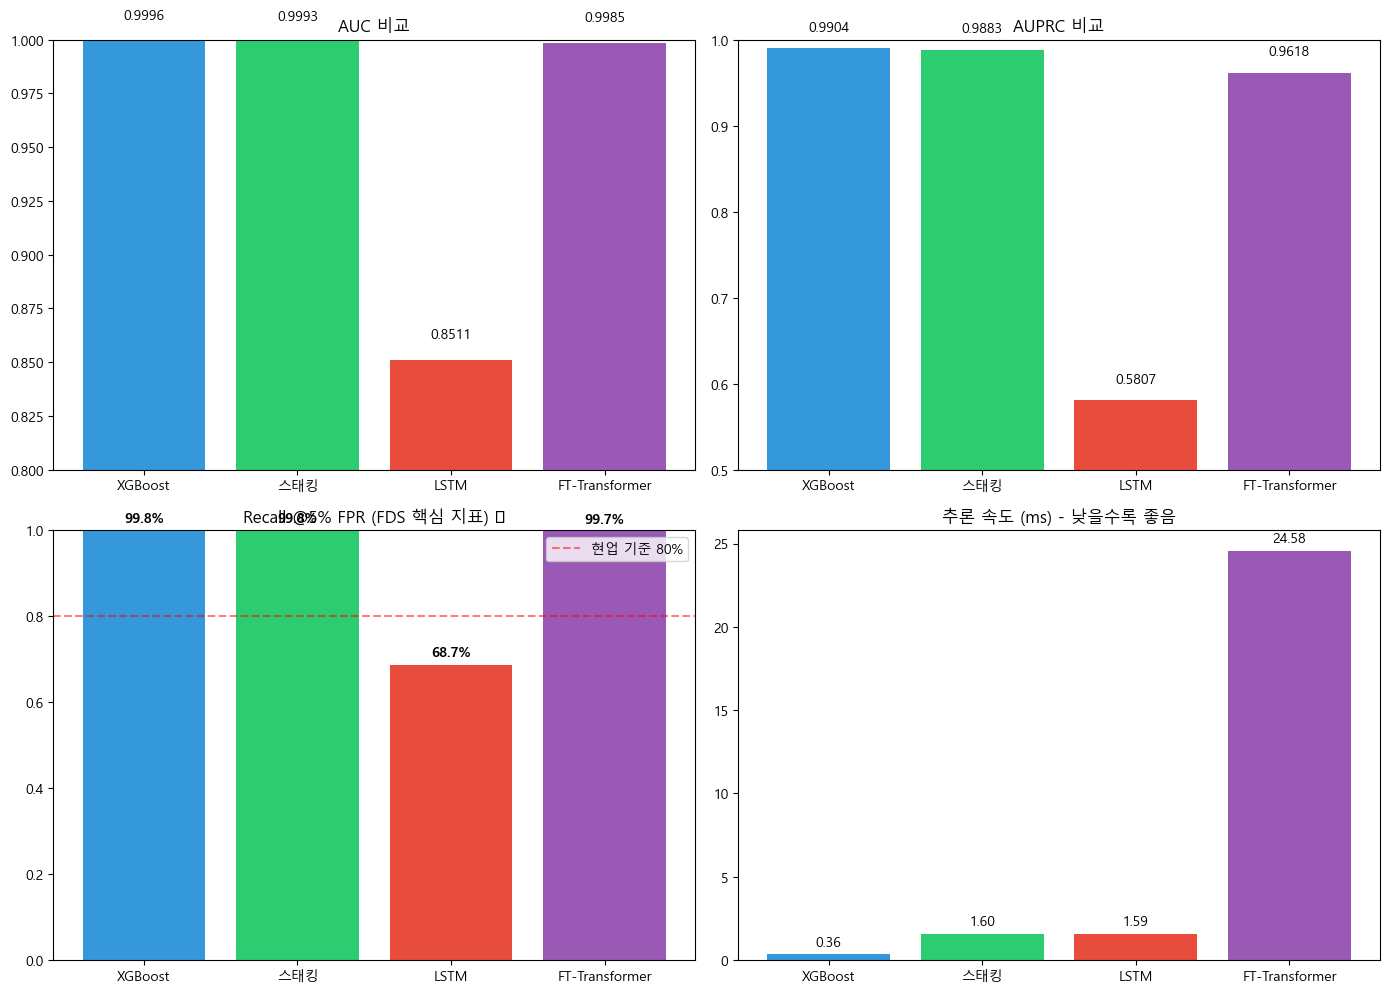

결과 이미지 저장: paysim_comparison_results.png


In [67]:
# 시각화 (Recall 추가)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = ['XGBoost', '스태킹', 'LSTM', 'FT-Transformer']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

# 1. AUC 비교
aucs = [xgb_auc, stacking_auc, lstm_auc, tf_auc]
axes[0, 0].bar(models, aucs, color=colors)
axes[0, 0].set_title('AUC 비교')
axes[0, 0].set_ylim(0.8, 1.0)
for i, v in enumerate(aucs):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center')

# 2. AUPRC 비교
auprcs = [xgb_auprc, stacking_auprc, lstm_auprc, tf_auprc]
axes[0, 1].bar(models, auprcs, color=colors)
axes[0, 1].set_title('AUPRC 비교')
axes[0, 1].set_ylim(0.5, 1.0)
for i, v in enumerate(auprcs):
    axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center')

# 3. Recall @5% FPR 비교 (FDS 핵심!)
recalls = [xgb_recall, stacking_recall, lstm_recall, tf_recall]
axes[1, 0].bar(models, recalls, color=colors)
axes[1, 0].set_title('Recall @5% FPR (FDS 핵심 지표) ⭐')
axes[1, 0].set_ylim(0, 1.0)
for i, v in enumerate(recalls):
    axes[1, 0].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')
axes[1, 0].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='현업 기준 80%')
axes[1, 0].legend()

# 4. 추론 속도 비교
latencies = [xgb_mean, stacking_mean, lstm_mean, tf_mean]
axes[1, 1].bar(models, latencies, color=colors)
axes[1, 1].set_title('추론 속도 (ms) - 낮을수록 좋음')
for i, v in enumerate(latencies):
    axes[1, 1].text(i, v + 0.5, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('paysim_comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("결과 이미지 저장: paysim_comparison_results.png")

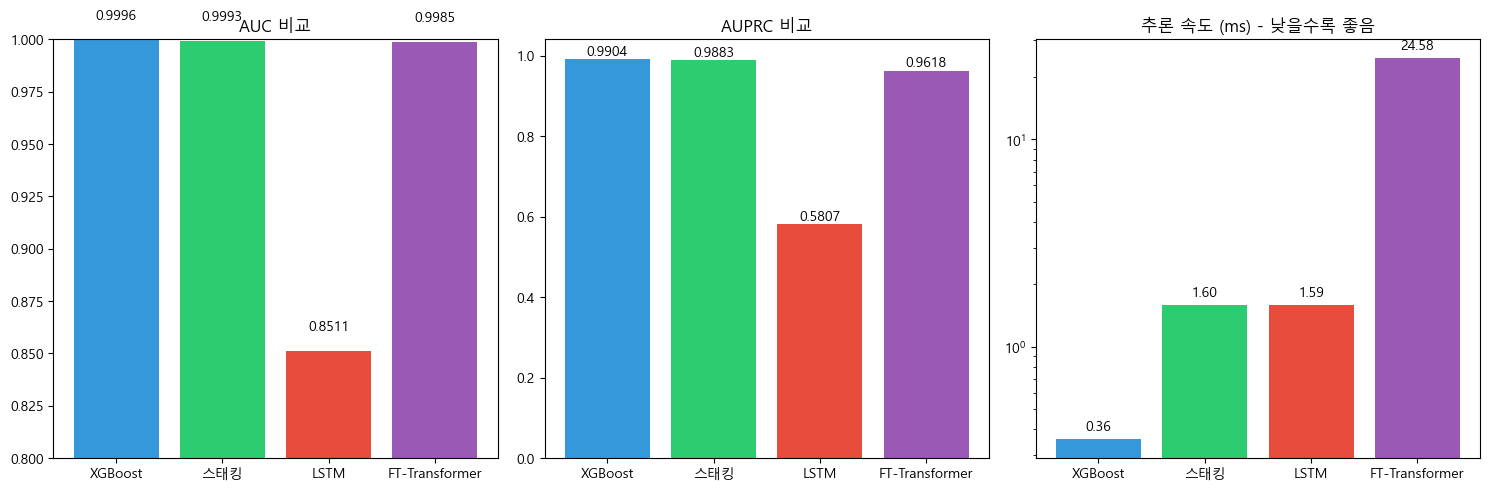

In [68]:
# 간단한 시각화 (3열)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['XGBoost', '스태킹', 'LSTM', 'FT-Transformer']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

# AUC 비교
aucs = [xgb_auc, stacking_auc, lstm_auc, tf_auc]
axes[0].bar(models, aucs, color=colors)
axes[0].set_title('AUC 비교')
axes[0].set_ylim(0.8, 1.0)
for i, v in enumerate(aucs):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center')

# AUPRC 비교
auprcs = [xgb_auprc, stacking_auprc, lstm_auprc, tf_auprc]
axes[1].bar(models, auprcs, color=colors)
axes[1].set_title('AUPRC 비교')
for i, v in enumerate(auprcs):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center')

# 추론 속도 비교 (로그 스케일)
latencies = [xgb_mean, stacking_mean, lstm_mean, tf_mean]
axes[2].bar(models, latencies, color=colors)
axes[2].set_title('추론 속도 (ms) - 낮을수록 좋음')
axes[2].set_yscale('log')
for i, v in enumerate(latencies):
    axes[2].text(i, v * 1.1, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [69]:
print("=" * 70)
print("결론")
print("=" * 70)
print()
print("1. PaySim vs IEEE-CIS:")
print(f"   - IEEE-CIS LSTM: AUC 0.70 (실패)")
print(f"   - PaySim LSTM:   AUC {lstm_auc:.4f}")
print(f"   → Global Sliding Window 한계로 여전히 트리 모델 대비 낮음")
print()
print("2. 성능 순위 (AUC):")
sorted_by_auc = sorted(zip(models, aucs), key=lambda x: x[1], reverse=True)
for i, (m, a) in enumerate(sorted_by_auc, 1):
    print(f"   {i}. {m}: AUC {a:.4f}")
print()
print("3. Recall @5% FPR (FDS 핵심 지표) ⭐:")
recalls = [xgb_recall, stacking_recall, lstm_recall, tf_recall]
sorted_by_recall = sorted(zip(models, recalls), key=lambda x: x[1], reverse=True)
for i, (m, r) in enumerate(sorted_by_recall, 1):
    status = "✅ 현업 기준 충족" if r >= 0.8 else "❌ 기준 미달"
    print(f"   {i}. {m}: {r:.1%} {status}")
print()
print("4. 추론 속도:")
sorted_by_speed = sorted(zip(models, latencies), key=lambda x: x[1])
for i, (m, l) in enumerate(sorted_by_speed, 1):
    print(f"   {i}. {m}: {l:.2f}ms")
print()
print("5. 최종 결론:")
print("   - 성능 + Recall 최고: XGBoost / 트리 스태킹")
print("   - 속도 최고: XGBoost")
print("   - FT-Transformer: 현업 수준 구현했으나 트리 대비 이점 없음")
print("   - LSTM: Global Sliding Window로 의미 있는 패턴 학습 실패")
print("   → PaySim에서는 피처 엔지니어링 + 트리 모델이 최선")

결론

1. PaySim vs IEEE-CIS:
   - IEEE-CIS LSTM: AUC 0.70 (실패)
   - PaySim LSTM:   AUC 0.8511
   → Global Sliding Window 한계로 여전히 트리 모델 대비 낮음

2. 성능 순위 (AUC):
   1. XGBoost: AUC 0.9996
   2. 스태킹: AUC 0.9993
   3. FT-Transformer: AUC 0.9985
   4. LSTM: AUC 0.8511

3. Recall @5% FPR (FDS 핵심 지표) ⭐:
   1. XGBoost: 99.8% ✅ 현업 기준 충족
   2. 스태킹: 99.8% ✅ 현업 기준 충족
   3. FT-Transformer: 99.7% ✅ 현업 기준 충족
   4. LSTM: 68.7% ❌ 기준 미달

4. 추론 속도:
   1. XGBoost: 0.36ms
   2. LSTM: 1.59ms
   3. 스태킹: 1.60ms
   4. FT-Transformer: 24.58ms

5. 최종 결론:
   - 성능 + Recall 최고: XGBoost / 트리 스태킹
   - 속도 최고: XGBoost
   - FT-Transformer: 현업 수준 구현했으나 트리 대비 이점 없음
   - LSTM: Global Sliding Window로 의미 있는 패턴 학습 실패
   → PaySim에서는 피처 엔지니어링 + 트리 모델이 최선


In [ ]:
print("=" * 70)
print("면접 Q&A")
print("=" * 70)
print()
print('Q: "왜 PaySim으로 재실험했나요?"')
print('A: "IEEE-CIS에서 LSTM AUC 0.70으로 실패한 원인을 분석했습니다.')
print('   V1~V339가 PCA 익명화된 피처라서 시계열 패턴이 없었습니다.')
print('   PaySim은 실제 거래 시퀀스가 있어서 공정 비교가 가능했습니다."')
print()
print('Q: "시간 윈도우 집계 피처는 어떻게 설계했나요?"')
print('A: "현업 논문을 참고해 12개 피처를 설계했습니다.')
print('   1시간/24시간/7일 윈도우별 거래 빈도와 금액, 잔액 변화율 등입니다.')
print('   Vectorized 연산으로 100만 건을 처리합니다."')
print()
print('Q: "FT-Transformer를 왜 사용했나요?"')
print('A: "단순 Transformer가 아닌 현업 수준 구현을 위해 pytorch_tabular의')
print('   FT-Transformer를 사용했습니다. 각 피처를 개별 토큰으로 임베딩하고,')
print('   Self-Attention으로 피처 간 상호작용을 학습합니다.')
print('   논문 수준 구현이지만, PaySim에서는 XGBoost 대비 이점이 없었습니다."')
print()
print('Q: "추론 속도 측정 결과는?"')
print(f'A: "XGBoost {xgb_mean:.1f}ms, FT-Transformer {tf_mean:.1f}ms로 ')
print(f'   {tf_mean/xgb_mean:.0f}배 차이났습니다.')
print('   DL 모델이 더 느리지만, 배치 처리나 하이브리드 아키텍처로 해결 가능합니다."')

In [70]:
# 임시 파일 정리
import os
for f in ['lstm_best.pt', 'transformer_best.pt']:
    if os.path.exists(f):
        os.remove(f)

print("\n" + "=" * 70)
print("1-11 완료!")
print("다음: 1-12 하이브리드 서빙 (LSTM 속도 문제 해결)")
print("=" * 70)


1-11 완료!
다음: 1-12 하이브리드 서빙 (LSTM 속도 문제 해결)
